In [1]:
# Link: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data

# 0. Download data from Kaggle

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
# uplaod "kaggle.json" and 'utils.py' 
from google.colab import files
upload = files.upload();
!mv kaggle.json ~/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!kaggle datasets download -d keplersmachines/kepler-labelled-time-series-data -p /content  # 
!unzip kepler-labelled-time-series-data.zip 
!ls

Saving kaggle.json to kaggle.json
Saving utils.py to utils.py
- path is now set to: {/content}
 88% 49.0M/55.9M [00:04<00:00, 7.54MB/s]
100% 55.9M/55.9M [00:04<00:00, 11.9MB/s]
Archive:  kepler-labelled-time-series-data.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            
exoTest.csv   kepler-labelled-time-series-data.zip  utils.py
exoTrain.csv  sample_data


## 0.1 Set up

In [10]:
%load_ext autoreload
%autoreload 2

from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import scipy
from scipy.signal import spectrogram
from scipy.ndimage import uniform_filter1d

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from tqdm.notebook import tqdm, trange

from utils import label_dict, labelTransform, scores_predict, label_balance
from utils import model_evaluator
from utils import plot_flux_spectra_scipy, get_spectra_scipy
from utils import data_transformer_final
from utils import conv1d_block,Metrics_f1_precision_recall

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Exploration 

In [5]:
trainDF = pd.read_csv('exoTrain.csv')
testDF = pd.read_csv('exoTest.csv')
trainDF.head(2)
trainDF.tail(2)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,...,-167.69,-56.86,7.56,37.40,-81.13,-20.1,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.9,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.4,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.8,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,6.29,-4.33,5.12,-2.24,-3.27,-7.51,-4.22,-0.82,-1.34,-6.76,-9.87,-2.18,6.43,-6.42,-6.75,-3.84,-0.56,-5.66,-4.30,-7.31,-5.81,-11.12,-4.53,4.29,-0.64,3.72,-4.25,3.12,8.85,-2.78,...,2.25,7.69,2.57,-7.28,-6.67,-8.64,-4.62,-2.87,-1.23,-3.89,-5.00,-1.68,-7.25,-0.65,0.04,-5.86,-7.83,-9.63,-12.70,-0.65,-8.66,-2.84,-8.58,-3.63,-7.44,-4.98,-3.60,-12.21,-6.65,-5.05,10.86,-3.23,-5.1,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55
5086,1,323.28,306.36,293.16,287.67,249.89,218.30,188.86,178.93,118.93,130.68,104.50,63.03,72.07,198.89,570.46,208.08,26.42,44.18,39.85,71.55,81.54,48.87,61.10,49.82,38.50,28.64,20.10,15.07,33.55,36.00,-29.34,-47.82,186.07,112.91,98.15,79.33,55.77,25.82,10.99,...,-32.79,-17.46,-4.60,168.11,22.56,-34.79,-0.85,-5.64,-15.34,27.73,31.34,15.93,1.88,-5.05,7.50,27.73,-22.82,-40.24,-26.11,-39.12,-26.63,31.11,24.86,42.61,30.88,17.34,-9.08,23.18,22.94,13.89,71.19,0.97,55.2,-1.63,-5.50,-25.33,-41.31,-16.72,-14.09,27.82


In [6]:
# information of the train data. 
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [7]:
# counts of labels 2 and 1
trainDF.iloc[:,0].value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

##1. 1 Label Transformation

This is a very special dataset. In some sense, this is a time series data set. But the time axis do not along the rows but the columns. So each row itself is a time sequence along its columns. And the columns can not be taken as features directly, since the values of a column at different rows do not share the same meaning. 

Whatever, firstly, let's get the traing feature data, X_train, and label data, y_train, and do the label transformation: $1\rightarrow0$ (Non Exoplanet) and $2\rightarrow1$ (Exoplanet). 

In [8]:
# training data
X_train, Y_train = labelTransform(trainDF)
X_train.shape
print('')
np.unique(Y_train, return_counts=True)

(5087, 3197)

(array([0., 1.]), array([5050,   37]))

In [9]:
# test data
X_test, Y_test = labelTransform(testDF)

## 1.2 Visualization

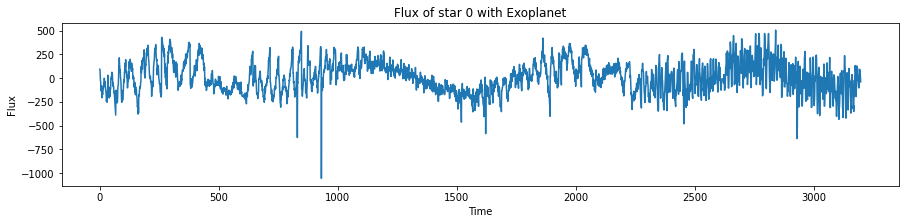

In [ ]:
i_row = 0
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

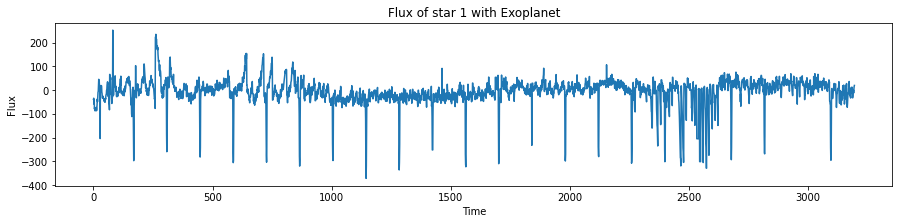

In [ ]:
i_row = 1
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

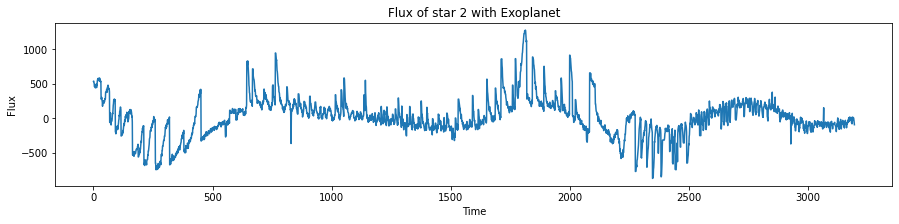

In [ ]:
i_row = 2
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

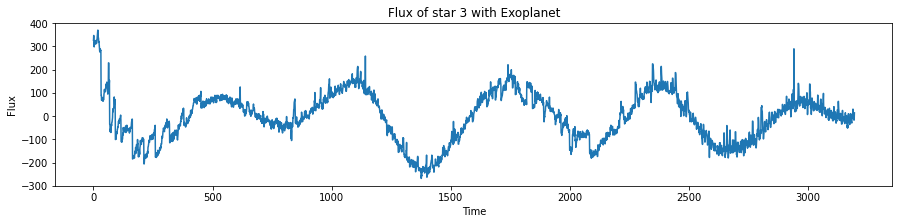

In [ ]:
i_row = 3
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

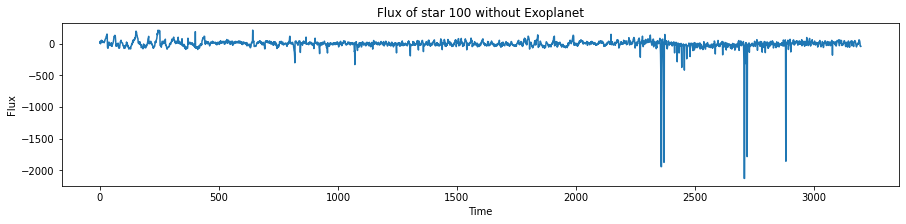

In [ ]:
i_row = 100
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

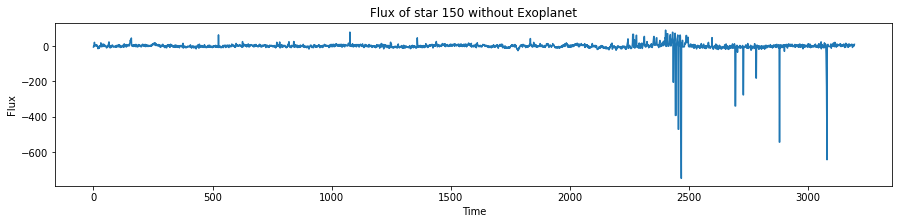

In [ ]:
i_row = 150
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

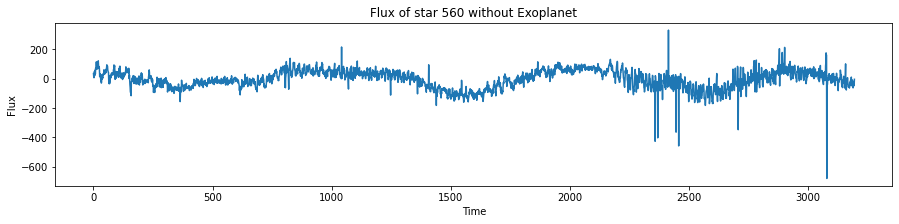

In [ ]:
i_row = 560
plt.figure(figsize=(15,3))
plt.title(f'Flux of star {i_row} {label_dict[Y_train[i_row]]}')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.plot(X_train[i_row,:])
plt.show();

# 2. Naively Try

In this section, we try the algorithms of Random Forest Classifier and Linear Support Vector Machine to classify the non exoplanet and the exoplanet by using the raw data.

#2.1 Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state=1)
y_pre_train = cross_val_predict(rfc, X_train, Y_train, cv=5)
scores_predict(y_pre_train, Y_train)

Confusion matrix:
[[5050    0]
 [  37    0]]
precision:  0.0
recall:  0.0
accuracy:  0.9927265578926676
f1:  0.0
f1_macro:  0.4981750024662129
f1_micro:  0.9927265578926676
f1_weighted:  0.9891031108529094


{'accuracy': 0.9927265578926676, 'conf_matrix': array([[5050,    0],
        [  37,    0]]), 'f1': 0.0, 'f1_macro': 0.4981750024662129, 'f1_micro': 0.9927265578926676, 'f1_weighted': 0.9891031108529094, 'precision': 0.0, 'recall': 0.0}

# 2.2 Linear Support Vector Machine

In [ ]:
svc = LinearSVC(random_state=1)
y_pre_train = cross_val_predict(svc, X_train, Y_train, cv=5)
scores_predict(y_pre_train, Y_train)

Confusion matrix:
[[3274 1776]
 [  13   24]]
precision:  0.013333333333333334
recall:  0.6486486486486487
accuracy:  0.648319245134657
f1:  0.026129559063690806
f1_macro:  0.40577198835996103
f1_micro:  0.648319245134657
f1_weighted:  0.7798918031942843


{'accuracy': 0.648319245134657, 'conf_matrix': array([[3274, 1776],
        [  13,   24]]), 'f1': 0.026129559063690806, 'f1_macro': 0.40577198835996103, 'f1_micro': 0.648319245134657, 'f1_weighted': 0.7798918031942843, 'precision': 0.013333333333333334, 'recall': 0.6486486486486487}

# 2.3 Oversample to balance the data
The above result is bad, due to the imbalanced training data.
Let us balance the labels by oversampling the minority class.
In Cross Validaton, we should not over sample the test batch, but only trarining batch. So let us call "model_evaluator()" which uses a customed CV splitter and cross-validation predicter to evaluate the model.


In [ ]:
rfc = RandomForestClassifier(random_state=1)
model_evaluator(X_train, Y_train, rfc, n_splits=5)

Length of Training: 4069, length of Testing:1018
Length of Training: 4069, length of Testing:1018
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Confusion matrix:
[[5047    3]
 [  37    0]]
precision:  0.0
recall:  0.0
accuracy:  0.9921368193434245
f1:  0.0
f1_macro:  0.49802644562857706
f1_micro:  0.9921368193434245
f1_weighted:  0.988808158216754


{'accuracy': 0.9921368193434245, 'conf_matrix': array([[5047,    3],
        [  37,    0]]), 'f1': 0.0, 'f1_macro': 0.49802644562857706, 'f1_micro': 0.9921368193434245, 'f1_weighted': 0.988808158216754, 'precision': 0.0, 'recall': 0.0}

In [ ]:
svc = LinearSVC(random_state=1)
model_evaluator(X_train, Y_train, svc, n_splits=5)

Length of Training: 4069, length of Testing:1018
Length of Training: 4069, length of Testing:1018
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Confusion matrix:
[[3276 1774]
 [  14   23]]
precision:  0.012799109627156371
recall:  0.6216216216216216
accuracy:  0.6485158246510714
f1:  0.025081788440567066
f1_macro:  0.405346649615967
f1_micro:  0.6485158246510714
f1_weighted:  0.7800798418849428


{'accuracy': 0.6485158246510714, 'conf_matrix': array([[3276, 1774],
        [  14,   23]]), 'f1': 0.025081788440567066, 'f1_macro': 0.405346649615967, 'f1_micro': 0.6485158246510714, 'f1_weighted': 0.7800798418849428, 'precision': 0.012799109627156371, 'recall': 0.6216216216216216}

We believe if a model performs well by using 'cv_pred()', it would perform well on the test data.

# 2.3 Normilizer
Let us try the normalization. Here, we use 'sklearn.preprocessing.Normalizer' to normalize the data along each row.

In [ ]:
normaler = Normalizer()
X_train_nor = normaler.fit_transform(X_train)

In [ ]:
rfc = RandomForestClassifier(random_state=1, max_samples=None)
model_evaluator(X_train_nor, Y_train, rfc, n_splits=5)

Length of Training: 4069, length of Testing:1018
Length of Training: 4069, length of Testing:1018
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Confusion matrix:
[[5048    2]
 [  37    0]]
precision:  0.0
recall:  0.0
accuracy:  0.9923333988598388
f1:  0.0
f1_macro:  0.49807597434632456
f1_micro:  0.9923333988598388
f1_weighted:  0.9889064951637268


{'accuracy': 0.9923333988598388, 'conf_matrix': array([[5048,    2],
        [  37,    0]]), 'f1': 0.0, 'f1_macro': 0.49807597434632456, 'f1_micro': 0.9923333988598388, 'f1_weighted': 0.9889064951637268, 'precision': 0.0, 'recall': 0.0}

In [ ]:
svc = LinearSVC(random_state=1)
model_evaluator(X_train_nor, Y_train, svc, n_splits=5)

Length of Training: 4069, length of Testing:1018
Length of Training: 4069, length of Testing:1018
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Confusion matrix:
[[5008   42]
 [  31    6]]
precision:  0.125
recall:  0.16216216216216217
accuracy:  0.9856496953017495
f1:  0.1411764705882353
f1_macro:  0.5669704337280556
f1_micro:  0.9856496953017495
f1_weighted:  0.9865704213867775


{'accuracy': 0.9856496953017495, 'conf_matrix': array([[5008,   42],
        [  31,    6]]), 'f1': 0.1411764705882353, 'f1_macro': 0.5669704337280556, 'f1_micro': 0.9856496953017495, 'f1_weighted': 0.9865704213867775, 'precision': 0.125, 'recall': 0.16216216216216217}

It seems that normalizing the data improve LinearSVC (f1: $0.025\rightarrow0.14$), althought have no effect on RandomForestClassifier. 

## 2.4 Standard Scaler
Let me try 'StandardScaler'. However, as we have displayed before, the columns of the dataset can not be treated as features. So, we will apply 'StandardScaler' along the rows.

In [ ]:
STDScaler = StandardScaler()
X_train_std = STDScaler.fit_transform(X_train.T).T

In [ ]:
rfc = RandomForestClassifier(random_state=1)
model_evaluator(X_train_std, Y_train, rfc, n_splits=5)

Length of Training: 4069, length of Testing:1018
Length of Training: 4069, length of Testing:1018
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Confusion matrix:
[[5049    1]
 [  37    0]]
precision:  0.0
recall:  0.0
accuracy:  0.9925299783762532
f1:  0.0
f1_macro:  0.4981254932912392
f1_micro:  0.9925299783762532
f1_weighted:  0.9890048127071979


{'accuracy': 0.9925299783762532, 'conf_matrix': array([[5049,    1],
        [  37,    0]]), 'f1': 0.0, 'f1_macro': 0.4981254932912392, 'f1_micro': 0.9925299783762532, 'f1_weighted': 0.9890048127071979, 'precision': 0.0, 'recall': 0.0}

In [ ]:
svc = LinearSVC(random_state=1)
model_evaluator(X_train_std, Y_train, svc, n_splits=5)

Length of Training: 4069, length of Testing:1018
Length of Training: 4069, length of Testing:1018
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Length of Training: 4070, length of Testing:1017
Confusion matrix:
[[4727  323]
 [  31    6]]
precision:  0.0182370820668693
recall:  0.16216216216216217
accuracy:  0.9304108511893061
f1:  0.032786885245901634
f1_macro:  0.49834694996389706
f1_micro:  0.9304108511893061
f1_weighted:  0.9571345663254679


{'accuracy': 0.9304108511893061, 'conf_matrix': array([[4727,  323],
        [  31,    6]]), 'f1': 0.032786885245901634, 'f1_macro': 0.49834694996389706, 'f1_micro': 0.9304108511893061, 'f1_weighted': 0.9571345663254679, 'precision': 0.0182370820668693, 'recall': 0.16216216216216217}

No improvement is obtained.

#3 Spectrogram
Here, we try extract the spectrum from the data and then use the spectral to train models. We expect the spectrun of each row has its own character that can tell whether an exoplanet exists or not.



## 3.1 Visualization

We use the help function, "plot_flux_spectra_scipy", to plot the fluxes and the corresponding spectral.

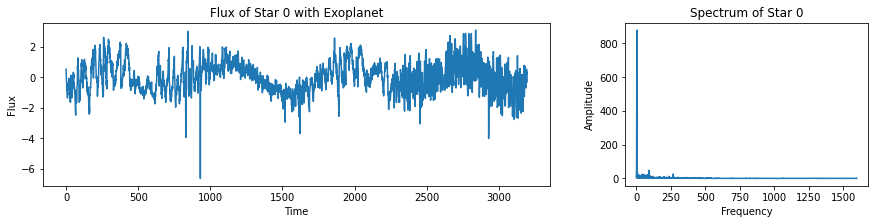

In [ ]:
i_row = 0
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

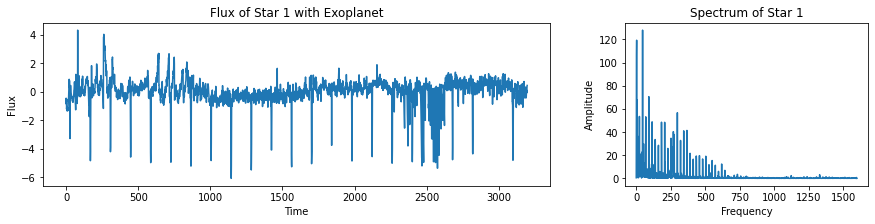

In [ ]:
i_row = 1
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

In [ ]:
i_row = 2
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

In [ ]:
i_row = 20
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

In [ ]:
i_row = 100
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

In [ ]:
i_row = 250
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

In [ ]:
i_row = 560
title_flux = f'Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:], title_flux, title_spectrum)

Above, from the visualization, it seems that there is not difference between the spectral of exoplanets and non-exoplanets. Whatever, let us extract the spectral and train models.

##3.2 Extract the spectra
Here, we transform the training data into the corresponding spectra by using the function "get_spectra_scipy()".

### 3.2.1 Normalizer And Sepctral

In [ ]:
normaler = Normalizer()
X_train_nor = normaler.fit_transform(X_train)
X_train_nor_sepctra = get_spectra_scipy(X_train_nor)

In [ ]:
RFS = RandomForestClassifier(random_state=1)
model_evaluator(X_train_nor_sepctra, Y_train, RFS, n_splits=5)

In [ ]:
model_evaluator(X_train_nor_sepctra, Y_train, LinearSVC(random_state=1), n_splits=5)

Random Forest Classifier becomes better on the spectral. But, Linear Support Vector becomes worse.

#### 3.2.1.1 Normalized Spectral
Let us noralize the spectral

In [ ]:
normaler = Normalizer()
X_train_nor_sepctra_nor = normaler.fit_transform(X_train_nor_sepctra)

In [ ]:
RFS = RandomForestClassifier(random_state=1)
model_evaluator(X_train_nor_sepctra_nor, Y_train, RFS, n_splits=5)

In [ ]:
model_evaluator(X_train_nor_sepctra_nor, Y_train, LinearSVC(random_state=1), n_splits=5)

It seems that f1 of rfc is improved from 0.195 to o.311. But the recall of the rfc is not satisfying yet. 

Actually, since the spectral are normalized, the normalization before extracting the spectral becomes unnecessary due to the linearity of Fourier transformation and normalization. Let show it.

In [ ]:
X_train_sepctra = get_spectra_scipy(X_train)
normaler = Normalizer()
X_train_sepctra_nor = normaler.fit_transform(X_train_sepctra)

In [ ]:
X_train_nor_sepctra_nor[:2]-X_train_sepctra_nor[:2]

In [ ]:
model_evaluator(X_train_sepctra_nor, Y_train, LinearSVC(random_state=1), n_splits=5)

So, if we plan to normalize the spectral, then it is not necessary to standardize or normalize the data before doing the Fourier transformation.

## 3.3 Filtered by a uniform filter

Let us try to smoth the fluxes to eliminate the noise.

In [ ]:
STDScaler = StandardScaler()
X_train_std = STDScaler.fit_transform(X_train.T).T # standardlize each row
X_train_uniform_spectral = get_spectra_scipy(uniform_filter1d(X_train_std, 450, axis=1, mode='wrap')) # spectra

In [ ]:
rfc = RandomForestClassifier(random_state=1)
model_evaluator(X_train_uniform_spectral, Y_train, rfc, n_splits=5)

In [ ]:
model_evaluator(X_train_uniform_spectral, Y_train, LinearSVC(random_state=1), n_splits=5)

In [ ]:
STDScaler = StandardScaler()
X_train_std = STDScaler.fit_transform(X_train.T).T # standardlize each row
X_train_uniform_spectral = get_spectra_scipy(uniform_filter1d(X_train_std, 15, axis=1, mode='wrap')) # spectra

In [ ]:
rfc = RandomForestClassifier(random_state=1)
model_evaluator(X_train_uniform_spectral, Y_train, rfc, n_splits=5)

In [ ]:
model_evaluator(X_train_uniform_spectral, Y_train, LinearSVC(random_state=1), n_splits=5)

No much improvement is obtained by using the sepctral of the smoothed data.
Let us try to normalize the spectral
### 3.3.1 Normalize the spectral

In [ ]:
normaler = Normalizer()
X_train_uniform_spectral_nor = normaler.fit_transform(X_train_uniform_spectral)

In [ ]:
model_evaluator(X_train_uniform_spectral_nor, Y_train, RandomForestClassifier(random_state=1), n_splits=5)

In [ ]:
model_evaluator(X_train_uniform_spectral_nor, Y_train, LinearSVC(random_state=1), n_splits=5)

The result becomes worse!

## 3.4 Detrended Spectrum
In the above section, I used the spetral of the uniformly filtered data to train the models and made a little progress. In this section, I try to use the spectral of the detrened data to fit the model. Since the exoplanet only dminished the flux in a short time interval, we expect that removing the trend in the data might produce a better model.

### 3.4.1 Detrend Data

In [ ]:
i_row = 0
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

In [ ]:
i_row = 1
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

In [ ]:
i_row = 2
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

In [ ]:
i_row = 20
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

In [ ]:
i_row = 100
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

In [ ]:
i_row = 250
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

In [ ]:
i_row = 560
title_flux = f'Detrended Flux of Star {i_row} {label_dict[Y_train[i_row]]}'
title_spectrum = f'Spectrum of Detrended Flux of star {i_row}'
pxx = plot_flux_spectra_scipy(X_train_std[i_row,:]-uniform_filter1d(X_train_std[i_row,:], 50, mode='wrap'), title_flux, title_spectrum)

It seems that the frquencies of stars with exoplanets centered at the left side. Let us use the spectral to train the models.

### 3.4.2 Detrended Spectral

In [ ]:
# uniformly filtering --> detrended --> standarlize --> spectral
STDScaler = StandardScaler()
X_train_detrended = X_train - uniform_filter1d(X_train, 15, axis=1, mode='wrap')
X_train_detrended_std =  STDScaler.fit_transform(X_train_detrended.T).T
X_train_unif_detr_std_spectral = get_spectra_scipy(X_train_detrended_std) # spectra

In [ ]:
model_evaluator(X_train_unif_detr_std_spectral, Y_train, RandomForestClassifier(random_state=1), n_splits=5)

In [ ]:
model_evaluator(X_train_unif_detr_std_spectral, Y_train, LinearSVC(random_state=1), n_splits=5)

Up to now, this is the best result that we ever obtained. We believe that Support Vector Machine is better than Random Forest Classifier. Let us try to improve the model by normalize the detrended spectral
#### 3.4.2.1 Normalize the detrended spectral 
Below, we will just normalize the spectral and do not standardize or normalize the data before the Fourier transformation.

In [ ]:
# uniformly filtering --> detrended --> spectral --> normalization
X_train_detrended = X_train - uniform_filter1d(X_train, 15, axis=1, mode='wrap')
X_train_unif_detr_spectral = get_spectra_scipy(X_train_detrended) # spectra
normalizer = Normalizer()
X_train_unif_detr_spec_nor = normalizer.fit_transform(X_train_unif_detr_spectral)

In [ ]:
model_evaluator(X_train_unif_detr_spec_nor, Y_train, LinearSVC(random_state=1), n_splits=5)

The model is improved further after we normalize the spectral. Since only the weaker signal is related to the exsitence of exoplanets, let us to remove the outlier signal. First, let us try to clip the detrended data above zero.
#### 3.4.2.1 Clip the data above zero

In [ ]:
# uniformly filtering --> detrended --> standarlize --> spectral
X_train_detrended = X_train - uniform_filter1d(X_train, 15, axis=1, mode='wrap')
X_train_unif_detr_clip_spectral = get_spectra_scipy(np.clip(X_train_detrended, a_min=None, a_max=0)) # spectra
normalizer = Normalizer()
X_train_unif_detr_clip_spec_nor = normalizer.fit_transform(X_train_unif_detr_clip_spectral)

In [ ]:
model_evaluator(X_train_unif_detr_clip_spec_nor, Y_train, LinearSVC(random_state=1), n_splits=5)

The result becomes worse. It might be too aggressive by clipping above zero.

#### 3.4.2.2 Remove the outlier

We take the outlier-removing function, "reduce_upper_outliers()" from here:
[Kaggle:0.75 Precision/0.60 Recall Linear SVC](https://www.kaggle.com/aleksod/0-75-precision-0-60-recall-linear-svc)
to remove the outliers.

In [ ]:
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    '''
    Since we are looking at dips in the data, we should remove upper outliers.
    The function is taken from here:
    https://www.kaggle.com/muonneutrino/exoplanet-data-visualization-and-exploration
    '''
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values:
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
       # print(sorted_values[:30])
        for j in range(remove):
            idx = sorted_values.index[j]
            #print(idx)
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            #print(idx,idx_num)
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)] # corrected from 'FLUX-' to 'FLUX.'
                
                count += 1
            new_val /= count # count will always be positive here
            #print(new_val)
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.at[i,idx] = new_val
    return df

In [ ]:
X_train_detrended = X_train - uniform_filter1d(X_train, 15, axis=1, mode='wrap')
df_detrend = pd.DataFrame(X_train_detrended, columns=trainDF.columns[1:])
X_train_detrended_redu = reduce_upper_outliers(df_detrend).values
X_train_unif_detr_redu_spectral = get_spectra_scipy(X_train_detrended_redu) # spectra
normalizer = Normalizer()
X_train_unif_detr_redu_spec_nor = normalizer.fit_transform(X_train_unif_detr_redu_spectral)

In [ ]:
model_evluator(X_train_unif_detr_redu_spec_nor, Y_train, LinearSVC(random_state=1), n_splits=5)

No improvement appears.

## 3.5 Check on test data
Now let us check our best model (LinearSVC with normalized spectral of detrended data) on the test data.

Here, we use the function, "data_transformer_final()", to process the data in the following steps:
'1-d uniformly filter --> detrend --> extrac spectral --> normalize'.

Train the model with the whole training data.

In [16]:
size_filter = 15
X_train_unif_detr_spec_nor = data_transformer_final(X_train, size_filter, mode_filter='wrap')
#X_train_unif_detr_spec_nor_res, Y_train_res = label_balance(X_train_unif_detr_spec_nor, Y_train)
svc = LinearSVC(random_state=1,class_weight='balanced')
#svc.fit(X_train_unif_detr_spec_nor_res, Y_train_res)
svc.fit(X_train_unif_detr_spec_nor, Y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

Test on the testing data.

In [17]:
X_test_unif_detr_spec_nor = data_transformer_final(X_test, size_filter, mode_filter='wrap')
Y_test_pre = svc.predict(X_test_unif_detr_spec_nor)
scores=scores_predict(Y_test_pre, Y_test)

Confusion matrix:
[[565   0]
 [  2   3]]
precision:  1.0
recall:  0.6
accuracy:  0.9964912280701754
f1:  0.7499999999999999
f1_macro:  0.8741166077738516
f1_micro:  0.9964912280701754
f1_weighted:  0.9960557312007936


In [ ]:
# scores on the test data
scores=scores_predict(Y_test_pre, Y_test)

# 4  CNN-1D
Let us try 1-D convolution network to classify the data. This idea comes from [Kaggle: Mystery Planet (99.8% CNN)](https://www.kaggle.com/toregil/mystery-planet-99-8-cnn)


### 4.1 Training

### 4.1.1 Origin data and the uniformly-filtered data

In [11]:
# split the training data into training part and validation part
split = StratifiedShuffleSplit(1, test_size=0.2, random_state=1)
for train_idx, val_idx in split.split(X_train, Y_train):
    X_train_1, Y_train_1 = X_train[train_idx], Y_train[train_idx]
    X_val, Y_val = X_train[val_idx], Y_train[val_idx]

In [12]:
X_train_1.shape
Y_train_1.shape
X_val.shape
Y_val.shape

(4069, 3197)

(4069,)

(1018, 3197)

(1018,)

In [13]:
Counter(Y_train_1)
Counter(Y_val)

Counter({0.0: 4039, 1.0: 30})

Counter({0.0: 1011, 1.0: 7})

In [14]:
# deeply stack the standardized data and the uniformly filtered data
def std_uniform_filtered_dstack(x):
    STDScaler = StandardScaler()
    x_std = STDScaler.fit_transform(x.T).T # standardlize each row
    x_std_unif = uniform_filter1d(x_std, 15, axis=1, mode='wrap')
    return np.dstack((x_std, x_std_unif))

#### 4.2.1.1 Get the validation data

In [25]:
X_val_dstack = std_uniform_filtered_dstack(X_val)

In [26]:
from utils import conv1d_block, Metrics_f1_precision_recall
metrics = Metrics_f1_precision_recall(X_val_dstack, Y_val)

#### 4.2.1.2 Imbalaned Data
Deeply stack the standardized data and the filtered data and then training the model.

In [20]:
X_train_1_dstack = std_uniform_filtered_dstack(X_train_1)

In [26]:
K.clear_session()
model_1 = Sequential([
                    *conv1d_block(16, "conv1",  kernel_size=15, pool_size=4),
                    *conv1d_block(32, "conv2", kernel_size=15, pool_size=4),
                    *conv1d_block(64, "conv3", kernel_size=15, pool_size=4),
                    layers.Flatten(name="flatten"),
                    layers.Dense(128, use_bias=False, name="dense1"),
                    layers.BatchNormalization(name="dense1_bn"),
                    layers.Activation('relu', name="dense1_act"),
                    layers.Dropout(0.5, name='dropout1'),
                    layers.Dense(64, use_bias=False, name="dense2"),
                    layers.BatchNormalization(name="dense2_bn"),
                    layers.Activation('relu', name="dense2_act"),
                    layers.Dropout(0.5, name='dropout2'),
                    layers.Dense(1, use_bias=False, name="out"),
                    layers.Activation('sigmoid', name="out_act")
                   ], name="seq_cnn1d")


In [27]:
model_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [28]:
model_1.fit(X_train_1_dstack, Y_train_1, batch_size=32, epochs=40, 
          validation_data=(X_val_dstack, Y_val), callbacks=metrics)

Epoch 1/40
128/128 [==============================] - 23s 181ms/step - loss: 0.3140 - accuracy: 0.8894 - val_loss: 0.2127 - val_accuracy: 0.9931
Epoch 2/40
128/128 [==============================] - 23s 176ms/step - loss: 0.0863 - accuracy: 0.9887 - val_loss: 0.0805 - val_accuracy: 0.9931
Epoch 3/40
128/128 [==============================] - 22s 175ms/step - loss: 0.0617 - accuracy: 0.9919 - val_loss: 0.0393 - val_accuracy: 0.9931
Epoch 4/40
128/128 [==============================] - 22s 174ms/step - loss: 0.0532 - accuracy: 0.9926 - val_loss: 0.0376 - val_accuracy: 0.9931
Epoch 5/40
128/128 [==============================] - 22s 173ms/step - loss: 0.0479 - accuracy: 0.9926 - val_loss: 0.0385 - val_accuracy: 0.9931
Epoch 6/40
128/128 [==============================] - 23s 178ms/step - loss: 0.0433 - accuracy: 0.9926 - val_loss: 0.0345 - val_accuracy: 0.9931
Epoch 7/40
128/128 [==============================] - 23s 177ms/step - loss: 0.0437 - accuracy: 0.9926 - val_loss: 0.0315 - val_ac

#### 4.2.1.2 Balanced Data

In [27]:
# resample the training part
X_train_1_res, Y_train_1_res = label_balance(X_train_1, Y_train_1)
Counter(Y_train_1_res)

Counter({0.0: 4039, 1.0: 4039})

In [28]:
X_train_1_res_dstack = std_uniform_filtered_dstack(X_train_1_res)

In [32]:
X_train_1_res_dstack.shape
Y_train_1_res.shape

(8078, 3197, 2)

(8078,)

In [42]:
K.clear_session()
model_2 = Sequential([
                        *conv1d_block(16, "conv1",  kernel_size=15, pool_size=4),
                        *conv1d_block(32, "conv2", kernel_size=15, pool_size=4),
                        *conv1d_block(64, "conv3", kernel_size=15, pool_size=4),
                        layers.Flatten(name="flatten"),
                        layers.Dense(128, use_bias=False, name="dense1"),
                        layers.BatchNormalization(name="dense1_bn"),
                        layers.Activation('relu', name="dense1_act"),
                        layers.Dropout(0.5, name='dropout1'),
                        layers.Dense(64, use_bias=False, name="dense2"),
                        layers.BatchNormalization(name="dense2_bn"),
                        layers.Activation('relu', name="dense2_act"),
                        layers.Dropout(0.5, name='dropout2'),
                        layers.Dense(1, use_bias=False, name="out"),
                        layers.Activation('sigmoid', name="out_act")
                        ], name="seq_cnn1d")
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
model_2.fit(X_train_1_res_dstack, Y_train_1_res, batch_size=32, epochs=40, 
          validation_data=(X_val_dstack, Y_val), callbacks=metrics)

Epoch 1/40
253/253 [==============================] - 42s 165ms/step - loss: 0.1498 - accuracy: 0.9501 - val_loss: 0.0349 - val_accuracy: 0.9882
Epoch 2/40
123/253 [=============>................] - ETA: 20s - loss: 0.0419 - accuracy: 0.9919

### 4.2.2 Spectrum of the detrended data

In [ ]:
size_filter = 15
X_train_unif_detr_spec_nor = data_transformer_final(X_train_1, size_filter, mode_filter='wrap')
X_train_unif_detr_spec_nor_res, Y_train_res = label_balance(X_train_unif_detr_spec_nor, Y_train_1)
X_train_unif_detr_spec_nor_res = X_train_unif_detr_spec_nor_res[:, :, np.newaxis]
X_val_unif_detr_spec_nor = data_transformer_final(X_val, size_filter, mode_filter='wrap')
X_val_unif_detr_spec_nor = X_val_unif_detr_spec_nor[:, :, np.newaxis]

In [ ]:
X_train_unif_detr_spec_nor_res.shape
Y_train_res.shape
X_val_unif_detr_spec_nor.shape
Y_val.shape

(8078, 1599, 1)

(8078,)

(1018, 1599, 1)

(1018,)

In [ ]:
metrics = Metrics_f1_precision_recall(X_val_unif_detr_spec_nor, Y_val)

In [ ]:
K.clear_session()
model_3 = Sequential([
                    *conv1d_block(8, "conv1",  kernel_size=5, pool_size=8),
                    *conv1d_block(16, "conv2", kernel_size=5, pool_size=8),
                    *conv1d_block(32, "conv3", kernel_size=5, pool_size=8),
                    layers.Flatten(name="flatten"),
                    layers.Dense(128, use_bias=False, name="dense1"),
                    layers.BatchNormalization(name="dense1_bn"),
                    layers.Activation('relu', name="dense1_act"),
                    layers.Dropout(0.5, name='dropout1'),
                    layers.Dense(64, use_bias=False, name="dense2"),
                    layers.BatchNormalization(name="dense2_bn"),
                    layers.Activation('relu', name="dense2_act"),
                    layers.Dropout(0.5, name='dropout2'),
                    layers.Dense(1, use_bias=False, name="out"),
                    layers.Activation('sigmoid', name="out_act")
                   ], name="seq_cnn1d")


In [ ]:
model_3.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
model_3.fit(X_train_unif_detr_spec_nor_res, Y_train_res, batch_size=32, epochs=40, 
          validation_data=(X_val_unif_detr_spec_nor, Y_val), callbacks=metrics)

Epoch 1/40
253/253 [==============================] - 8s 32ms/step - loss: 0.1880 - accuracy: 0.9267 - val_loss: 0.0450 - val_accuracy: 0.9931
Epoch 2/40
253/253 [==============================] - 8s 32ms/step - loss: 0.0217 - accuracy: 0.9969 - val_loss: 0.0284 - val_accuracy: 0.9941
Epoch 3/40
253/253 [==============================] - 8s 31ms/step - loss: 0.0140 - accuracy: 0.9973 - val_loss: 0.0286 - val_accuracy: 0.9951
Epoch 4/40
253/253 [==============================] - 8s 31ms/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.0312 - val_accuracy: 0.9951
Epoch 5/40
253/253 [==============================] - 8s 31ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0255 - val_accuracy: 0.9951
Epoch 6/40
253/253 [==============================] - 8s 31ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0212 - val_accuracy: 0.9971
Epoch 7/40
253/253 [==============================] - 8s 31ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.0379 - val_accuracy: 0.9951

# **Visually Explan CNN**: Guided Grad CAM Visualization

In [ ]:
# Import the required libraraies
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the image apth and the last conv layer for VGG19
IMAGE_PATH = 'dog_cat_1.png'
LAYER_NAME='block5_conv4'
#Load the image
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
# Displaying the original image
plt.axis("off")
plt.imshow(img)
plt.show()
# Preprocess the image using vgg19 preprocess function
img =  tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(img, axis=0)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(x)

FileNotFoundError: ignored

In [ ]:
#Create the transfer learned model
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=True)

In [ ]:
'''create a model till  last convolutional layers to have the best compromise between high-level semantics and detailed spatial
information'''
gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output]
)
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [ ]:
# define the guided Relu
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [ ]:
# change the activation to guided Relu in gb_model
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [ ]:
with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
grads = tape.gradient(outputs,inputs)[0]

In [ ]:
inputs.shape

In [ ]:
outputs.shape

In [ ]:
grads.shape

In [ ]:
weights = tf.reduce_mean(grads, axis=(0, 1))

In [ ]:
weights = tf.reduce_mean(grads, axis=(0, 1))
grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    grad_cam += w * outputs[:, :, i]

In [ ]:
print(weights.shape)
grad_cam.shape

In [ ]:
layer_dict

In [ ]:
layer = tf.keras.layers.Dense(3)
layer.build((100, 100)) 

In [ ]:
len(layer.weights)